In [ ]:
pip install sklearn-crfsuite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn_crfsuite
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics

In [ ]:

# File path for the .conll file
file_path = 'gdpr-compliant-ner.conll'

# Read the file
with open(file_path, 'r') as f:
    lines = f.readlines()


In [ ]:
sentences = []  # Initialize sentences as an empty list
sentence = []  # Initialize sentence as an empty list

for line in lines:
    if line.strip():  # If the line is not empty
        token, tag = line.split()  # Split the line into token and tag
        sentence.append((token, tag))  # Append the (token, tag) pair to the sentence
    else:  # An empty line indicates the end of a sentence
        sentences.append(sentence)
        sentence = []  # Reset for the next sentence

# If the last sentence doesn't end with an empty line, append it
if sentence:
    sentences.append(sentence)

In [ ]:
# Convert the first sentence to a DataFrame for display
# You can change `sentences[0]` to display other sentences
df = pd.DataFrame(sentences[0], columns=['Token', 'Tag'])

In [ ]:
# Display the DataFrame in a readable format
df.head(25)

,Token,Tag
0,Privacy,O
1,Policy,O
2,Effective,O
3,:,O
4,June,O
5,29,O
6,",",O
7,2022,O
8,Snap,B-DC
9,Inc,I-DC


In [ ]:
num_sentences = len(sentences)
num_sentences


44

In [ ]:
# Flatten all sentences into one list of tokens and tags
all_tokens = [token for sentence in sentences for token in sentence]

# Create a DataFrame with all the tokens and tags
df_all = pd.DataFrame(all_tokens, columns=['Token', 'Tag'])

# Display the entire DataFrame (or the first few rows)
print(df_all.head())  # Show the first few rows of the combined dataset

       Token Tag
0    Privacy   O
1     Policy   O
2  Effective   O
3          :   O
4       June   O


In [ ]:
# Filter out rows where the 'Tag' is 'O'
df_cleansed = df_all[df_all['Tag'] != 'O']
df_cleansed['Tag'] = df_cleansed['Tag'].str.replace('B-', '').str.replace('I-', '')

# Reset the index for cleaner display
df_cleansed.reset_index(drop=True, inplace=True)

# Display the first few rows of the filtered DataFrame
df_cleansed.head()

<ipython-input-11-9c925d7e570d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleansed['Tag'] = df_cleansed['Tag'].str.replace('B-', '').str.replace('I-', '')


,Token,Tag
0,Snap,DC
1,Inc,DC
2,.,DC
3,When,RET
4,you,RET


In [ ]:
# Analyze the frequency of each tag
tag_counts = df_cleansed['Tag'].value_counts()


In [ ]:
pd.set_option('display.max_rows', None)
tag_counts.head(70)


,count
Tag,
RP,24625
PD,16453
OM,6401
P,4967
NPD,4629
LI,4306
RET,4005
TP,3306
CONS,2788


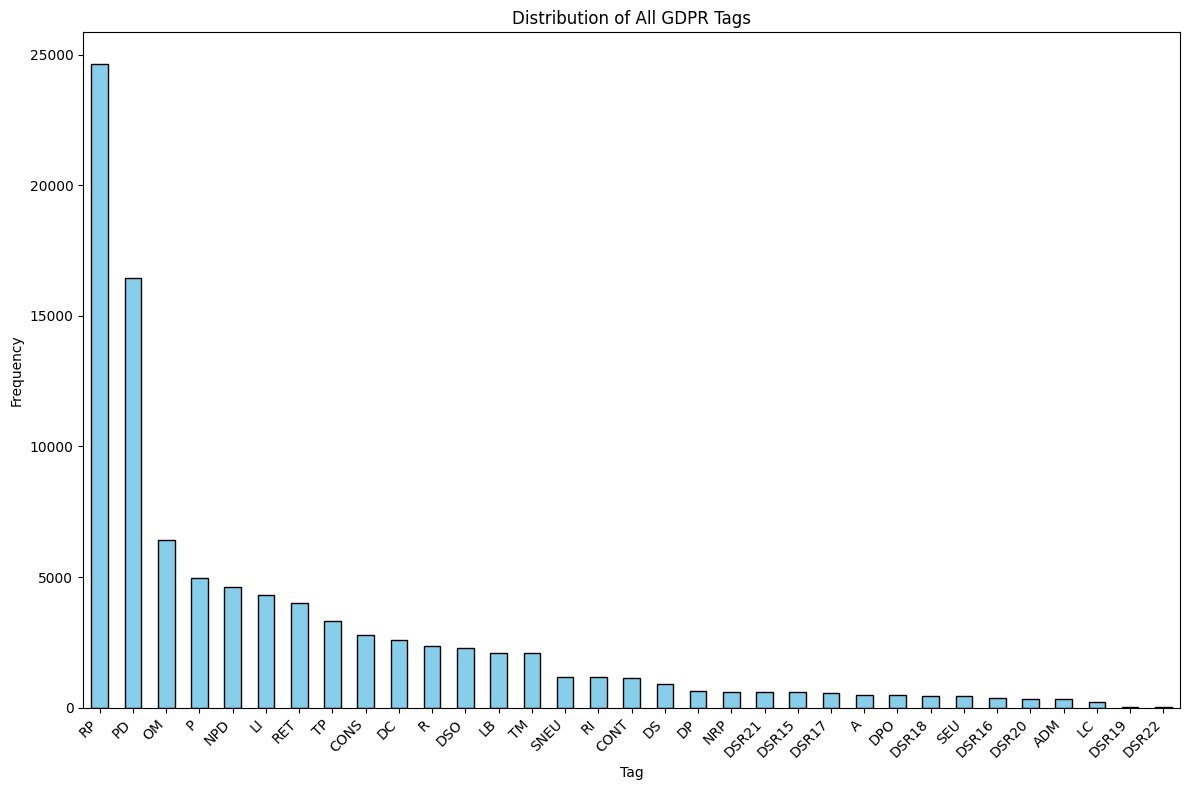

In [ ]:
# Plot all the tags
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of All GDPR Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def format_ner_data(sentences):
    X = []
    y = []

    for sentence in sentences:
        tokens = [token for token, tag in sentence]
        tags = [tag for token, tag in sentence]

        X.append(tokens)
        y.append(tags)

    return X, y

In [ ]:
def extract_features(sentence, i):
    token = sentence[i]

    features = {
        'token': token,
        'lowercase': token.lower(),
        'prefix-1': token[:1],
        'suffix-1': token[-1:],
        'is_capitalized': token[0].isupper(),
        'is_digit': token.isdigit(),
    }

    if i > 0:
        prev_token = sentence[i-1]
        features.update({
            'prev_token': prev_token,
            'prev_lowercase': prev_token.lower(),
            'prev_is_capitalized': prev_token[0].isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sentence)-1:
        next_token = sentence[i+1]
        features.update({
            'next_token': next_token,
            'next_lowercase': next_token.lower(),
            'next_is_capitalized': next_token[0].isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

In [ ]:
# Step 1: Format the NER data to extract tokens and tags
X_train, y_train = format_ner_data(sentences)

# Step 2: Extract features for each sentence in X_train
X_train_features = [extract_sentence_features(sentence) for sentence in X_train]


In [ ]:
def extract_sentence_features(sentence):
    return [extract_features(sentence, i) for i in range(len(sentence))]

# Prepare features for each sentence in X_train
X_train_features = [extract_sentence_features(sentence) for sentence in X_train]


In [ ]:
for i in range(len(X_train)):
    assert len(X_train[i]) == len(y_train[i]), f"Mismatch at sentence {i}: {len(X_train[i])} tokens, {len(y_train[i])} tags"


In [ ]:
# Step 1: Initialize the CRF model
crf = CRF(
    algorithm='lbfgs',  # Optimization algorithm
    max_iterations=100,  # Max number of iterations for the optimization
    all_possible_transitions=True  # Add transitions that were not observed during training
)

In [ ]:
# Train the CRF model
crf.fit(X_train_features, y_train)

# Predict on training data (or test data)
y_pred = crf.predict(X_train_features)

In [ ]:
# Evaluate the model


labels = list(crf.classes_)
metrics.flat_f1_score(y_train, y_pred, average='weighted', labels=labels)


0.6703519165453151

In [ ]:
# Assuming y_train and y_pred are your true and predicted labels
accuracy = metrics.flat_accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7074


In [ ]:
# Assuming y_train and y_pred are your true and predicted labels
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))  # Optional: sort labels by tag type

# Generate the classification report
report = metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels, digits=2)
print(report)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           O       0.76      0.91      0.83    177997
         B-A       0.29      0.01      0.03       135
         I-A       0.56      0.10      0.18       362
       B-ADM       0.00      0.00      0.00       123
       I-ADM       0.00      0.00      0.00       191
      B-CONS       0.39      0.10      0.16       759
      I-CONS       0.36      0.06      0.10      2029
      B-CONT       0.00      0.00      0.00       157
      I-CONT       0.21      0.02      0.04       986
        B-DC       0.48      0.08      0.14      1658
        I-DC       0.66      0.38      0.48       928
        B-DP       0.00      0.00      0.00       151
        I-DP       0.00      0.00      0.00       499
       B-DPO       0.00      0.00      0.00        58
       I-DPO       0.43      0.32      0.37       414
        B-DS       0.00      0.00      0.00       584
        I-DS       0.10      0.01      0.01       334
       B-DSO       0.64    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# List of labels from the CRF model, excluding 'O'
labels = list(crf.classes_)
if 'O' in labels:
    labels.remove('O')

# Sort the labels, first by entity type (B- or I-), then alphabetically
sorted_labels = sorted(labels, key=lambda name: (name.split('-')[-1], name))

# Generate classification report with sorted labels
report = metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels, digits=2)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         B-A       0.29      0.01      0.03       135
         I-A       0.56      0.10      0.18       362
       B-ADM       0.00      0.00      0.00       123
       I-ADM       0.00      0.00      0.00       191
      B-CONS       0.39      0.10      0.16       759
      I-CONS       0.36      0.06      0.10      2029
      B-CONT       0.00      0.00      0.00       157
      I-CONT       0.21      0.02      0.04       986
        B-DC       0.48      0.08      0.14      1658
        I-DC       0.66      0.38      0.48       928
        B-DP       0.00      0.00      0.00       151
        I-DP       0.00      0.00      0.00       499
       B-DPO       0.00      0.00      0.00        58
       I-DPO       0.43      0.32      0.37       414
        B-DS       0.00      0.00      0.00       584
        I-DS       0.10      0.01      0.01       334
       B-DSO       0.64      0.09      0.15       442
       I-DSO       0.71    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 1. Calculate accuracy
accuracy = metrics.flat_accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Calculate macro F1 (without weighting, treating all labels equally)
macro_f1 = metrics.flat_f1_score(y_train, y_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

# 3. Calculate weighted F1 (takes class frequency into account)
weighted_f1 = metrics.flat_f1_score(y_train, y_pred, average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

Accuracy: 0.7074
Macro F1-Score: 0.1881
Weighted F1-Score: 0.6704
